referenced from https://ws-choi.github.io/blog-kor/seminar/tutorial/mnist/pytorch/gan/GAN-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/

# Generative Adversarial Network with MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [14]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5,))])  # 3 for RGB channels이나 실제론 gray scale

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 100
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

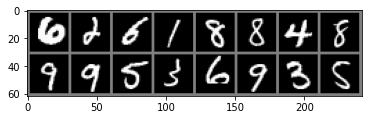

In [5]:
# Visualization
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [25]:
# Simple Generator
d_noise  = 100
d_hidden = 256

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

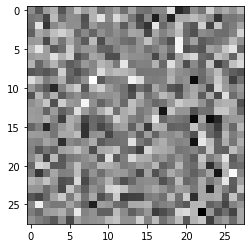

torch.Size([100, 784])


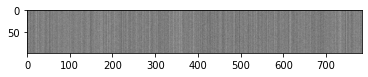

In [26]:
# Genrate Sample
def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
print(img_fake.size())
imshow_grid(img_fake)

In [11]:
# Simple Discriminator
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([128, 784])
torch.Size([128, 1])
tensor([[0.5025, 0.5087, 0.5098, 0.5100, 0.5090]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [12]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

(epoch 1/20) p_real: 0.999726, p_g: 0.000411
(epoch 2/20) p_real: 0.998838, p_g: 0.000243
(epoch 3/20) p_real: 0.994328, p_g: 0.012540
(epoch 4/20) p_real: 0.990433, p_g: 0.007823


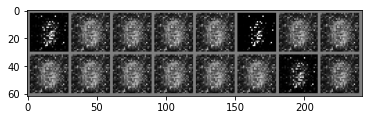

(epoch 5/20) p_real: 0.987222, p_g: 0.007135
(epoch 6/20) p_real: 0.961183, p_g: 0.149983
(epoch 7/20) p_real: 0.885782, p_g: 0.152858
(epoch 8/20) p_real: 0.870587, p_g: 0.099362


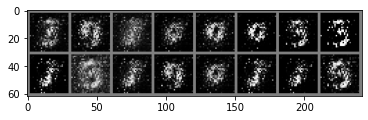

(epoch 9/20) p_real: 0.929408, p_g: 0.024588
(epoch 10/20) p_real: 0.942828, p_g: 0.126405
(epoch 11/20) p_real: 0.913785, p_g: 0.077031
(epoch 12/20) p_real: 0.940831, p_g: 0.088392


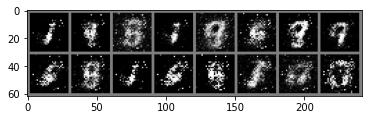

(epoch 13/20) p_real: 0.861348, p_g: 0.067940
(epoch 14/20) p_real: 0.891659, p_g: 0.089897
(epoch 15/20) p_real: 0.891959, p_g: 0.152921
(epoch 16/20) p_real: 0.784014, p_g: 0.084056


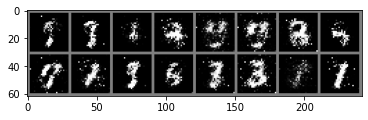

(epoch 17/20) p_real: 0.829070, p_g: 0.135858
(epoch 18/20) p_real: 0.818378, p_g: 0.139277
(epoch 19/20) p_real: 0.825976, p_g: 0.191929
(epoch 20/20) p_real: 0.808440, p_g: 0.194857


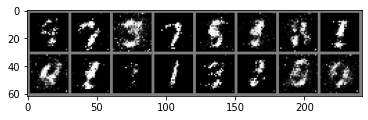

In [20]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

epochs = 20 # 200
for epoch in range(epochs):

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    print('(epoch %i/%d) p_real: %f, p_g: %f' % (epoch+1, epochs, p_real, p_fake))
    if (epoch+1) % (epochs//4) == 0:
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

### End training (Epoch 200)
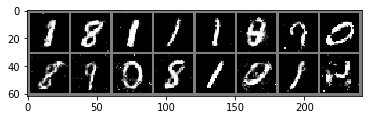

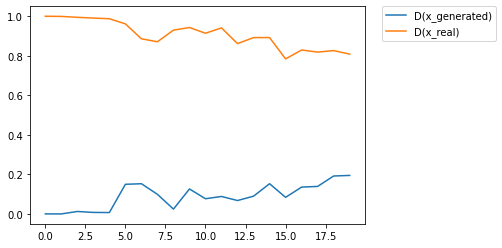

In [22]:
# Probability Tracing
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
# Comparison with real data
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))

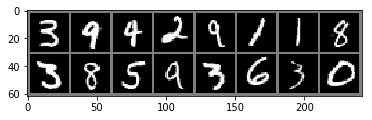

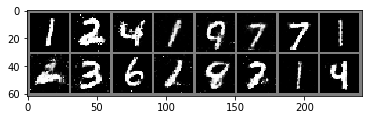